# <center> Проект: EDA + Feature Engineering. Обучение модели.

### Библеотеки для работы с данными

In [83]:
import pandas as pd
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns 
from scipy import stats # библиотека для расчетов
import random
import numpy as np
import category_encoders as ce

## Знакомство с DataFrame

In [84]:
data = pd.read_csv('hotels.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [85]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


## Обработка строковых значений
Главной задачей является, получить из строковых значений в дата фрейме информацию, которая поможет улучшить качество прогнозов модели. Так как модель не учиться на строковых значениях, нужно выделить главное и закодировать данные, что бы машина могла определить их наличие в дата-сете.

In [86]:
def get_days(days): #Функция для разделения строки 
    days = days.split(' ')
    
    return days[0]

data['days_since_review'] = data['days_since_review'].apply(get_days)
data['days_since_review'] = data['days_since_review'].astype(int)


def get_country(country):  #
    
    country = country.split()
    joined = ''

    if country[-1] == 'Kingdom':
      
        joined = ' '.join([country[-2], country[-1]])
            
        return joined
    else:
        return country[-2]
        
data['country_hotel'] = data['hotel_address'].apply(get_country)

display(data['country_hotel'].value_counts())


United Kingdom    196774
Barcelona          45132
Paris              44830
Amsterdam          43006
Vienna             29178
Milan              27883
Name: country_hotel, dtype: int64

После получения информации о городе в котором находиться отель, стоит задача закодировать эту информацию посредством проектирования новых принаков, которые будут являться маркером имея значения 0 или 1, обозначающим город.

In [87]:
#создание новых признаков принимающих значения 0 или 1 при помощи lambda функции
data['is_UK'] = data['country_hotel'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
data['is_Barcel'] = data['country_hotel'].apply(lambda x: 1 if x == 'Barcelona' else 0)
data['is_Paris'] = data['country_hotel'].apply(lambda x: 1 if x == 'Paris' else 0)
data['is_Amster'] = data['country_hotel'].apply(lambda x: 1 if x == 'Amsterdam' else 0)
data['is_Vienna'] = data['country_hotel'].apply(lambda x: 1 if x == 'Vienna' else 0)
data['is_Milan'] = data['country_hotel'].apply(lambda x: 1 if x == 'Milan' else 0)

Проверим наличие пустых значений в дата-фрейме.

In [88]:
data.isna().any()

hotel_address                                 False
additional_number_of_scoring                  False
review_date                                   False
average_score                                 False
hotel_name                                    False
reviewer_nationality                          False
negative_review                               False
review_total_negative_word_counts             False
total_number_of_reviews                       False
positive_review                               False
review_total_positive_word_counts             False
total_number_of_reviews_reviewer_has_given    False
reviewer_score                                False
tags                                          False
days_since_review                             False
lat                                            True
lng                                            True
country_hotel                                 False
is_UK                                         False
is_Barcel   

Так как у нас есть NaN значения в параметрах отвечающих за координаты расположения отеля, я заполню эти значения при помощи функции fillna(), в аргументе которой указан метод заполнения ffill, этот метод будет брать значение из сообветсвующей не пустой ячейки, думаю таким образом можно лучше скоректировать данные не взяв среднее значение этих параметров.

In [89]:
data[['lat', 'lng']] = data.groupby('country_hotel')[['lat', 'lng']].fillna(method='ffill')

Далее у нас признак в котором есть информация о том из какой страны приехал постоялец, таким образом вожно создать новый признак, который будет указывать, что постоялез является гостем в этой стране или нет. 

In [90]:
#Что бы быть увереным что признаки не будут отличаться, мы уберем все ненужные пробелы из строковых значений
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.lstrip().rstrip())
data['country_hotel'] = data['country_hotel'].apply(lambda x: x.lstrip().rstrip())
#создание нового признаком посредством сравнения страны отеля и постояльца
data['guest'] = data.apply(lambda x: True if x['reviewer_nationality'] != x['country_hotel'] else False, axis=1)
#получаем информацию о процентном соотношение жителей страны с туристами
round(data['guest'].mean(), 2)

0.67

В базе храниться большое количество тегов указывающие на различные особенности нахождения в отеле, начиная от типа номера и количества постояльцев, до того приехал ли кто то с детьми ил животными.

Конкретно в этом параметре содержиться 2368 тегов, каждый из которых можно так же закодировать и получить невероятный обьем не нужной информации, создав такое количество параметров, можно надолго затянуть процесс обучения.

Для себя я выделил два параметра, это количество ночей проживания и тип поездки.

In [91]:
'''
    Так как указаные пользователем теги находятся в списке, нужно их оттуда достать, 
    что бы было удобнее с ними работать. Я создал новый параметр new_tags, в котором
    будут храниться теги в более удобном виде
'''
data['new_tags'] = data['tags'].apply(lambda x: x.strip('[]').split(','))
data['new_tags']  = data['new_tags'].apply(lambda x: [y.strip("' '") for y in x])

display(data['new_tags'].explode().nunique())
display(data['new_tags'].explode().value_counts())

2368

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: new_tags, Length: 2368, dtype: int64

Далее идут функции которые достают значения хранящие в себе информацию о количестве ночей и типе поездки.

In [92]:

def get_night(nigh):
    for tag in nigh:
        tags = tag.split()
        if tags[0] == 'Stayed':
            return int(tags[1])
    return 0

data['nights'] = data['new_tags'].apply(get_night)
data['nights'] = data['nights'].astype(int)

def get_trip(trip):
    for tag in trip:
        t_type = tag.split()
        if 'trip' in t_type:
            return t_type[0]
    return 'No type'

data['trip'] = data['new_tags'].apply(get_trip)
#Однократное кодирование признака trip
encoding = ce.OneHotEncoder(cols=['trip'], use_cat_names=True)
trip_bin = encoding.fit_transform(data['trip'])
data = pd.concat([data, trip_bin], axis=1)
#удаление признаков 
data.drop(['tags', 'new_tags', 'trip'], axis=1)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,is_Barcel,is_Paris,is_Amster,is_Vienna,is_Milan,guest,nights,trip_Leisure,trip_Business,trip_No type
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,0,0,False,2,1,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,0,0,0,False,1,0,1,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,1,0,0,0,True,3,1,0,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,1,0,0,0,True,1,1,0,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,1,0,0,True,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,0,0,0,0,0,True,2,1,0,0
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,0,0,0,1,0,True,4,1,0,0
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,0,0,0,0,0,True,1,0,1,0
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,0,0,0,0,0,True,2,1,0,0


Далее идет самая интересная для меня часть в которой была реализована работа библеотеки nltk, данная библеотека может распозновать текст, а конкретно в этом случае высчитывать метрику количества негативных и положительных слов.

Так как в базе есть параметры в которых пользователь написал свои положительные и отрицательные отзывы, можно при помощи данной библеотеки получить общую метрику этих отзывов.

Таким образом можно получить хороший числовой параметр который будет означать общее впечатление постояльца, параметр принимает значение от -1 до 1. Если значение ближе к -1, это будет означать весьма негативное отношение пользователя к своему проживанию в отеле, а если значение ближе к 1, то это значит, что общее впечатление осталось положительным.

In [93]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()
#функция принимающаа значение отзыва пользователя
def get_compound(review):
    return sent_analyzer.polarity_scores(review)['compound']
#создание параметра который будет брать общее значение метрики отзыва
data['compound_review'] = data.apply(lambda row: get_compound(row['positive_review'] + row['negative_review']), axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [94]:
data.shape[1]

32

### Очистка данных
После преобразования и проектирования я получил 38 признаков, часть из которых является строковыми значениями. От них надо избавиться, что бы модель могла обучаться. Так же нужно избавиться от дубликатов, выбросов и сильной корреляции.

In [95]:
#Переменная в которой будут храниться все параметры типа object
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#Удаление параметров
data.drop(object_columns, axis = 1, inplace=True)

In [96]:
#Поверяем количество дубликатов
data_dupl = data.duplicated()
data_dupl.value_counts()

False    386485
True        318
dtype: int64

### Удаление дубликатов

In [97]:
data = data.drop_duplicates().reset_index(drop=True)

## Проверка мультиколлинеарности

<AxesSubplot: >

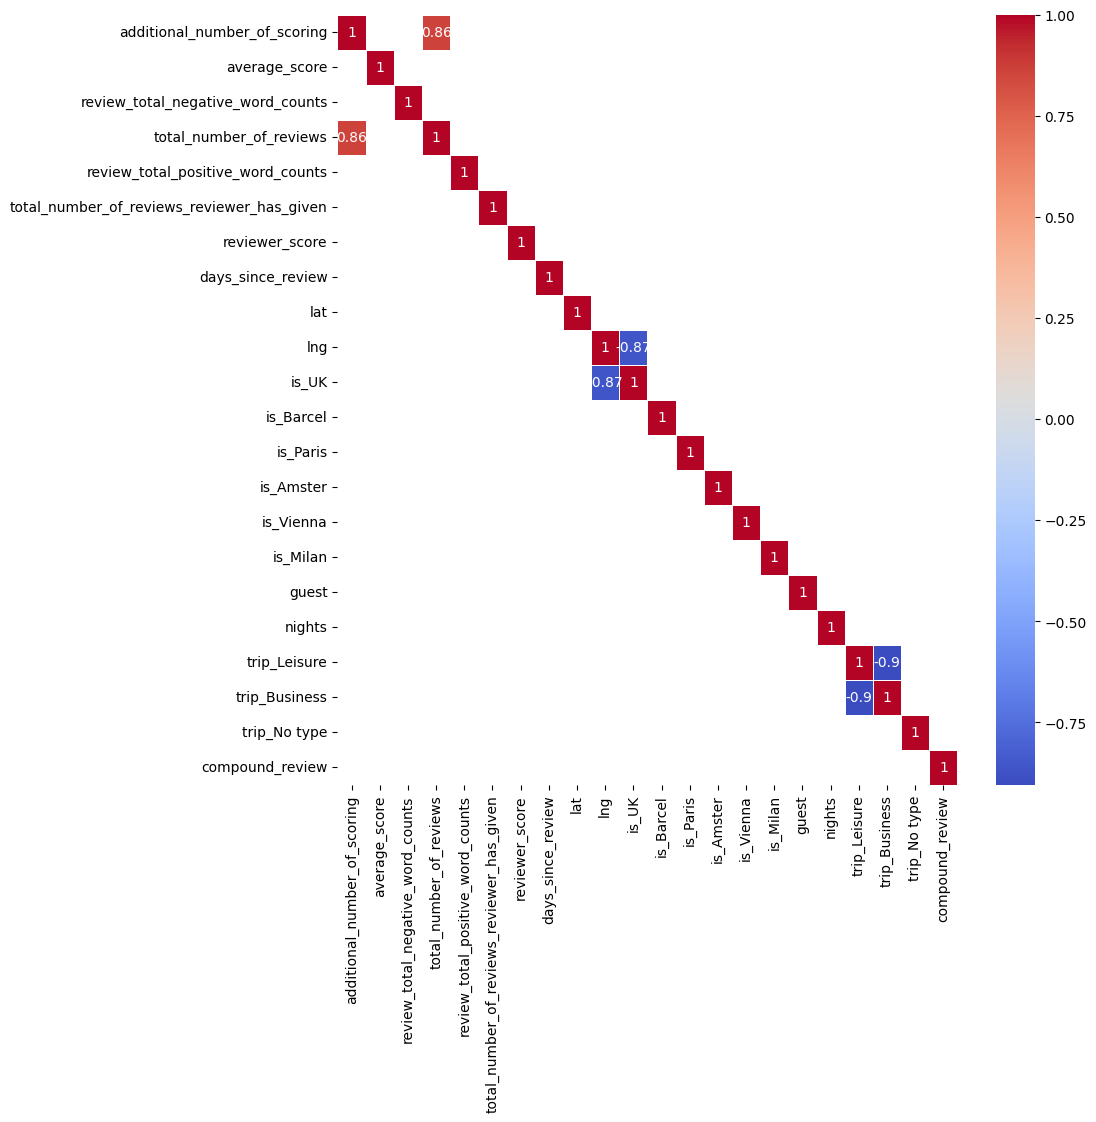

In [98]:
datacorr = data.corr(method='spearman')

# График
plt.figure(figsize=(10, 10)) 
sns.heatmap(
    data=datacorr[abs(datacorr) >= 0.7], 
    annot=True, 
    linewidths=.5, 
    cmap='coolwarm'
)

Просмотрев график корреляции спирмена видно 3 признака имеющие между собой сильную корреляцию.

Признаки additional_number_of_scoring и total_number_of_reviews имеют сильную корреляцию так как имеют почти, что одинаковое количество значений.

Что насчет признаком is_UK и lng, то тут я не знаю как это прокоментировать, возможно в ходе заполнения данных каким то образом значения которыми был заполнен признак lng начали склонятся в отрицательную сторону от признака is_UK.

Ну а корреляция признаков trip_Leisure и trip_Business естественна, так как они полностью противоположны друг другу.

## Обучение машины

In [99]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

In [100]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [101]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [102]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

In [103]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12888151502379172


## Вывод:

В ходе всех преобразований с данными был достигнут показатель МАРЕ в 13%, что на 0.5% меньше чем если вообще не обрабатывать данные. Из этого можно сделать вывод, что я плохо справился с поставленной задачей, так как на самом деле сделал не так уж и много.

Так же хочется отметить, что мой локальный компьютер с большим трудом обрабатывает, кодирует и преобразует новые параметры в DataFrame, что я влется проблемой, так как только на обучение модели копмьютер тратит не меньше 10 минут.

Уверен данный показатель может составить и 10% при должных преобразованиях данных и создании более эффективных признаков.